# 声明：内容为学习笔记，仅供学习交流

# 使用决策树和随机森林预测员工离职率

 预测一个员工离职的可能性.
数据来源: https://www.kaggle.com/ludobenistant/hr-analytics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

# 数据读取

In [2]:
# 读入数据到Pandas Dataframe "df"
df = pd.read_csv('data/data76953/HR_comma_sep.csv', index_col=None)

# 数据预处理

In [3]:
# 检测是否有缺失数据
df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

In [4]:
# 数据的样例
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
# 重命名
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

In [6]:
# 将预测标签‘是否离职’放在第一列
front = df['turnover']
df.drop(labels=['turnover'], axis=1, inplace = True)
df.insert(0, 'turnover', front)
df.head()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,sales,low
1,1,0.80,0.86,5,262,6,0,0,sales,medium
2,1,0.11,0.88,7,272,4,0,0,sales,medium
3,1,0.72,0.87,5,223,5,0,0,sales,low
4,1,0.37,0.52,2,159,3,0,0,sales,low


## 数据统计分析

In [7]:
# 共14999个样本，每一个样本中包含10个特征
df.shape

(14999, 10)

In [8]:
# 特征数据类型. 
df.dtypes

turnover                 int64
satisfaction           float64
evaluation             float64
projectCount             int64
averageMonthlyHours      int64
yearsAtCompany           int64
workAccident             int64
promotion                int64
department              object
salary                  object
dtype: object

In [9]:
# 离职率
turnover_rate = df.turnover.value_counts() / len(df)
turnover_rate

0    0.761917
1    0.238083
Name: turnover, dtype: float64

In [10]:
# 显示统计数据
df.describe()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.238083,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268
std,0.425924,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281
min,0.000000,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.000000,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.000000,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000
75%,0.000000,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [11]:
# 分组的平均数据统计
turnover_Summary = df.groupby('turnover')
turnover_Summary.mean()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


##  相关性分析
***
**正相关的特征:** 
- projectCount VS evaluation: 0.349333
- projectCount VS averageMonthlyHours:  0.417211
- averageMonthlyHours VS evaluation: 0.339742

**负相关的特征:**
 - satisfaction VS turnover:  -0.388375

**思考:**
- 什么特征的影响最大?
- 什么特征之间相关性最大?


,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,1.000000,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,-0.061788
satisfaction,-0.388375,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,0.025605
evaluation,0.006567,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,-0.008684
projectCount,0.023787,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,-0.006064
averageMonthlyHours,0.071287,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,-0.003544
yearsAtCompany,0.144822,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433
workAccident,-0.154622,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,0.039245
promotion,-0.061788,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,1.000000


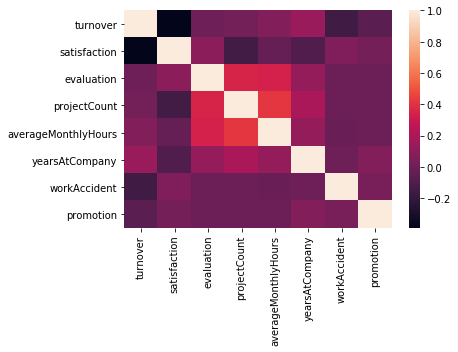

In [12]:
# 相关性矩阵
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

In [13]:
# 比较离职和未离职员工的满意度
emp_population = df['satisfaction'][df['turnover'] == 0].mean()
emp_turnover_satisfaction = df[df['turnover']==1]['satisfaction'].mean()

print( '未离职员工满意度: ' + str(emp_population))
print( '离职员工满意度: ' + str(emp_turnover_satisfaction) )

未离职员工满意度: 0.666809590479524
离职员工满意度: 0.4400980117614114


## 进行 T-Test
***
进行一个 t-test, 看离职员工的满意度是不是和未离职员工的满意度明显不同


In [14]:
import scipy.stats as stats
# 满意度的t-Test
stats.ttest_1samp(a = df[df['turnover']==1]['satisfaction'], # 离职员工的满意度样本
                  popmean = emp_population)  # 未离职员工的满意度均值

Ttest_1sampResult(statistic=-51.33034867547431, pvalue=0.0)

T-Test 显示pvalue **(0)** 非常小, 所以他们之间是显著不同的

In [15]:
degree_freedom = len(df[df['turnover']==1])
# 临界值
LQ = stats.t.ppf(0.025,degree_freedom)  # 95%致信区间的左边界
RQ = stats.t.ppf(0.975,degree_freedom)  # 95%致信区间的右边界
print ('The t-分布 左边界: ' + str(LQ))
print ('The t-分布 右边界: ' + str(RQ))

The t-分布 左边界: -1.9606285215955626
The t-分布 右边界: 1.9606285215955621


Text(0.5,1,'工作评价的概率密度函数 - 离职 V.S. 未离职')

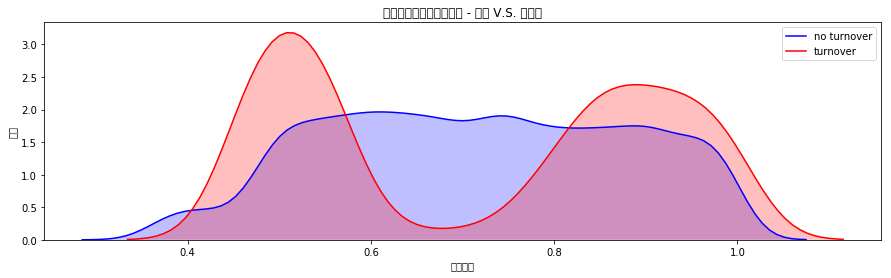

In [16]:
# 工作评价的概率密度函数估计
fig = plt.figure(figsize=(15,4),)
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'evaluation'] , color='b',shade=True,label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'evaluation'] , color='r',shade=True, label='turnover')
ax.set(xlabel='工作评价', ylabel='频率')
plt.title('工作评价的概率密度函数 - 离职 V.S. 未离职')

Text(0.5,1,'月工作时长（时） - 离职 V.S. 未离职')

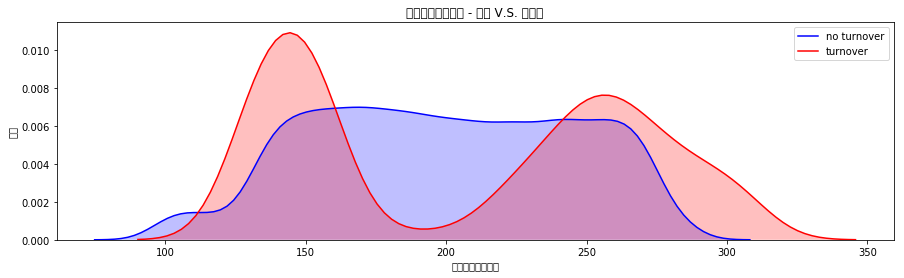

In [17]:
# 月平均工作时长概率密度函数估计
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'averageMonthlyHours'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'averageMonthlyHours'] , color='r',shade=True, label='turnover')
ax.set(xlabel='月工作时长（时）', ylabel='频率')
plt.title('月工作时长（时） - 离职 V.S. 未离职')

Text(0.5,1,'员工满意度 - 离职 V.S. 未离职')

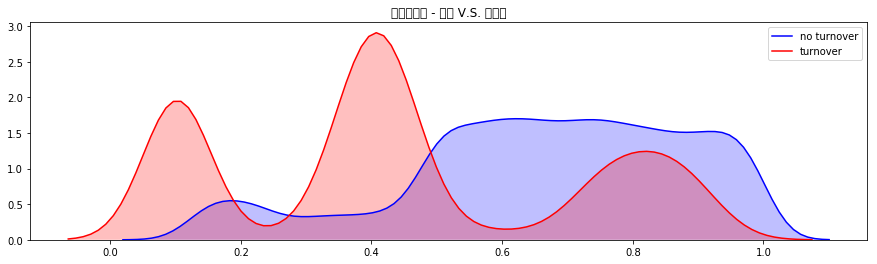

In [18]:
# 员工满意度概率密度函数估计
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(df.loc[(df['turnover'] == 0),'satisfaction'] , color='b',shade=True, label='no turnover')
ax=sns.kdeplot(df.loc[(df['turnover'] == 1),'satisfaction'] , color='r',shade=True, label='turnover')
plt.title('员工满意度 - 离职 V.S. 未离职')

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve

In [20]:
# 将string类型转换为整数类型
df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

# 产生X, y，即特征值与目标值
target_name = 'turnover'
X = df.drop('turnover', axis=1)
y = df[target_name]

# 将数据分为训练和测试数据集
# 注意参数 stratify = y 意味着在产生训练和测试数据中, 离职的员工的百分比等于原来总的数据中的离职的员工的百分比
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=123, stratify=y)
# 显示前5行数据
df.head()

,turnover,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion,department,salary
0,1,0.38,0.53,2,157,3,0,0,7,1
1,1,0.80,0.86,5,262,6,0,0,7,2
2,1,0.11,0.88,7,272,4,0,0,7,2
3,1,0.72,0.87,5,223,5,0,0,7,1
4,1,0.37,0.52,2,159,3,0,0,7,1


# 决策树和随机森林Decision Tree V.S. Random Forest 
***

In [22]:
!pip install pydotplus

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 286kB 18.1MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-cp37-none-any.whl size=24567 sha256=f7056ed404e1f6990bd25a172058d9029d5106f475a50b9c4237326534c6cf42
  Stored in directory: /home/aistudio/.cache/pip/wheels/be/29/7a/36a7ecae7907726ecc5a66d072bd94df72ec602bff3a693f0d
Successfully built pydotplus


In [23]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus 

## 决策树

In [24]:
# 实例化
dtree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_depth=3, # 定义树的深度, 可以用来防止过拟合
    min_weight_fraction_leaf=0.01 # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
    )
# 训练
dtree = dtree.fit(X_train,y_train)
# 指标计算
dt_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
print ("决策树 AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, dtree.predict(X_test)))

决策树 AUC = 0.93
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1714
           1       0.93      0.89      0.91       536

    accuracy                           0.96      2250
   macro avg       0.95      0.93      0.94      2250
weighted avg       0.96      0.96      0.96      2250



## 决策树可视化

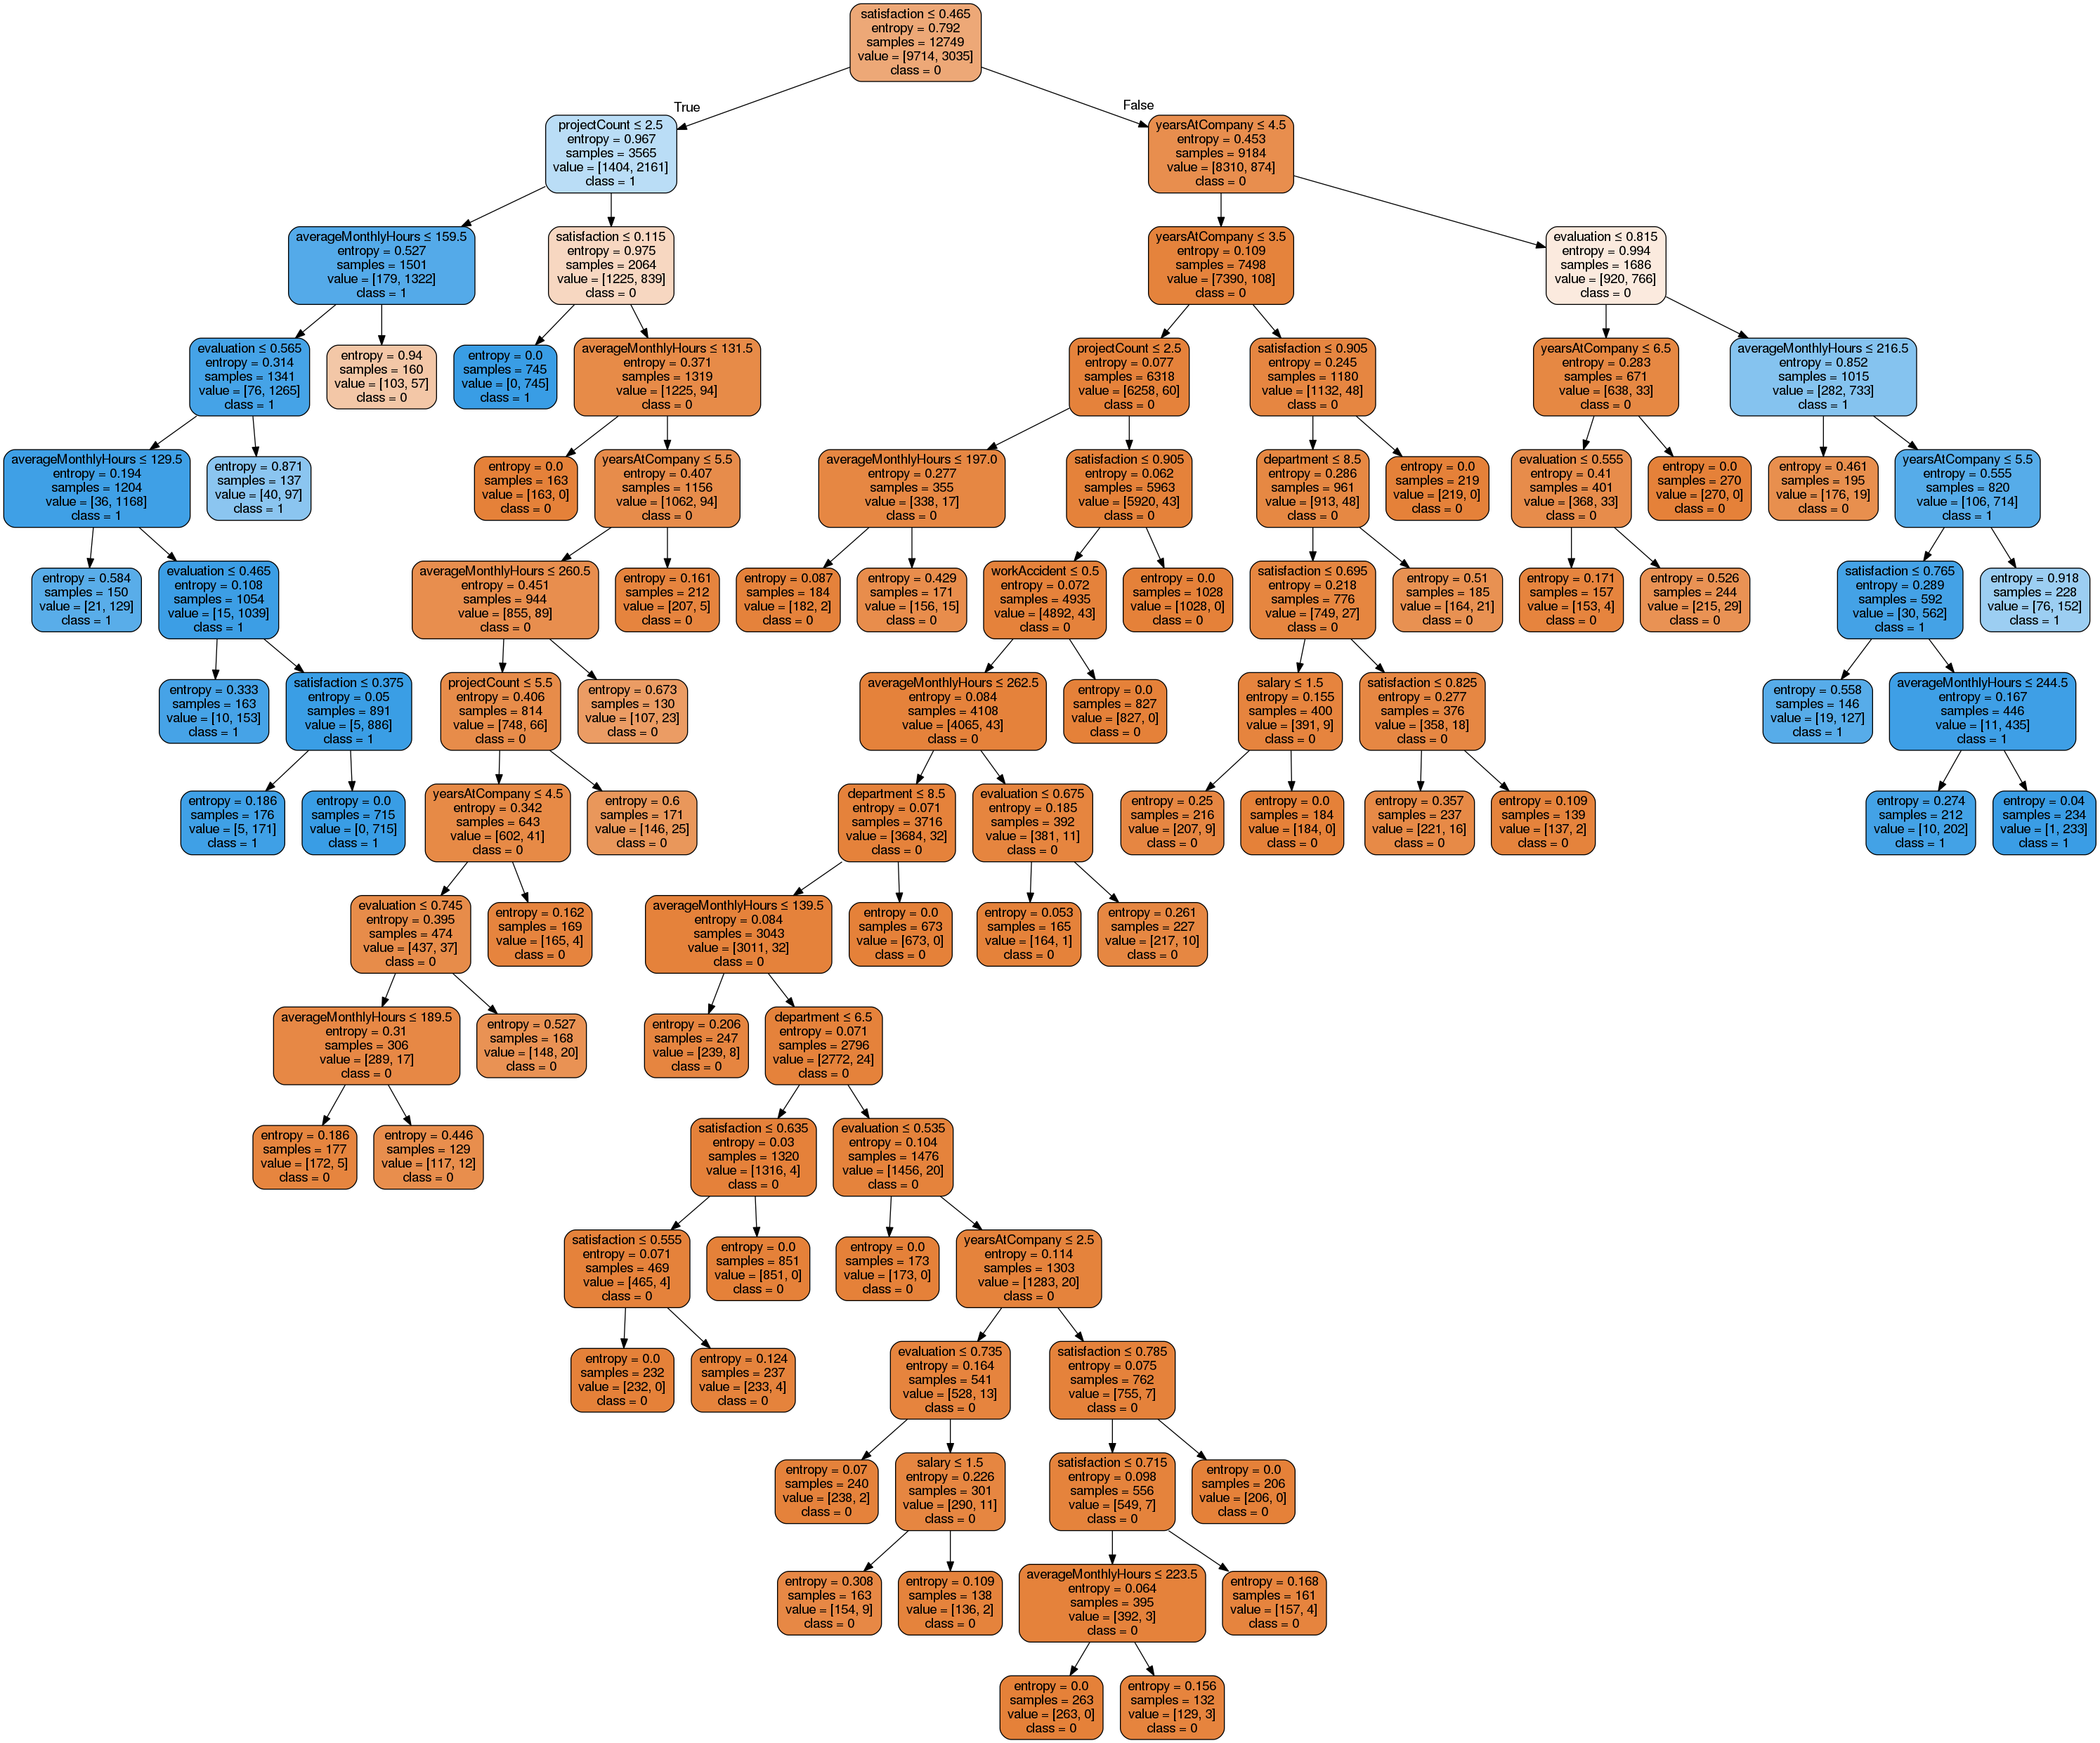

In [25]:
# 需安装GraphViz和pydotplus进行决策树的可视化
# 特征向量
feature_names = df.columns[1:]
# 文件缓存
dot_data = StringIO()
# 将决策树导入到dot中
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_names,class_names=['0','1'])
# 将生成的dot文件生成graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# 将结果存入到png文件中
graph.write_png('diabetes.png')
# 显示
Image(graph.create_png())

## 决策树的特征重要性分析

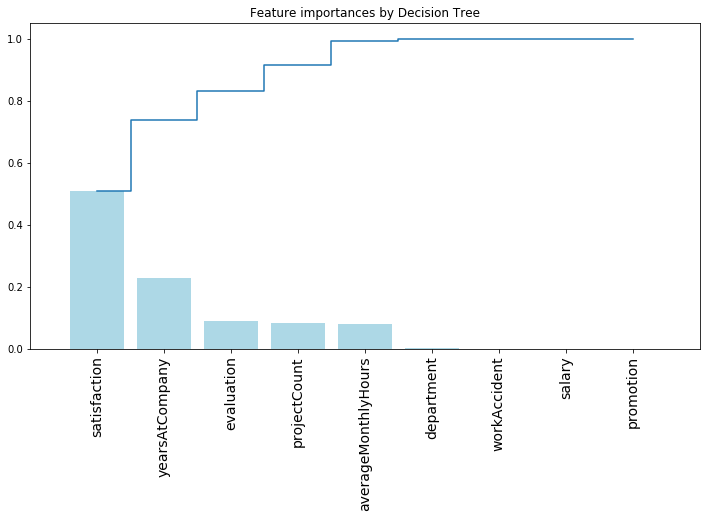

In [26]:
# 获取特征重要性
importances = dtree.feature_importances_
# 获取特征名称
feat_names = df.drop(['turnover'],axis=1).columns
# 排序
indices = np.argsort(importances)[::-1]
# 绘图
plt.figure(figsize=(12,6))
plt.title("Feature importances by Decision Tree")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

## 随机森林

In [27]:
# 实例化随机森林
rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=3, 
    max_depth=None, # 定义树的深度, 可以用来防止过拟合
    min_samples_split=10, # 定义至少多少个样本的情况下才继续分叉
    #min_weight_fraction_leaf=0.02 # 定义叶子节点最少需要包含多少个样本(使用百分比表达), 防止过拟合
    )
# 模型训练
rf.fit(X_train, y_train)
# 计算指标参数
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("随机森林 AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))

随机森林 AUC = 0.96
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1714
           1       0.98      0.93      0.95       536

    accuracy                           0.98      2250
   macro avg       0.98      0.96      0.97      2250
weighted avg       0.98      0.98      0.98      2250



## 随机森林可视化

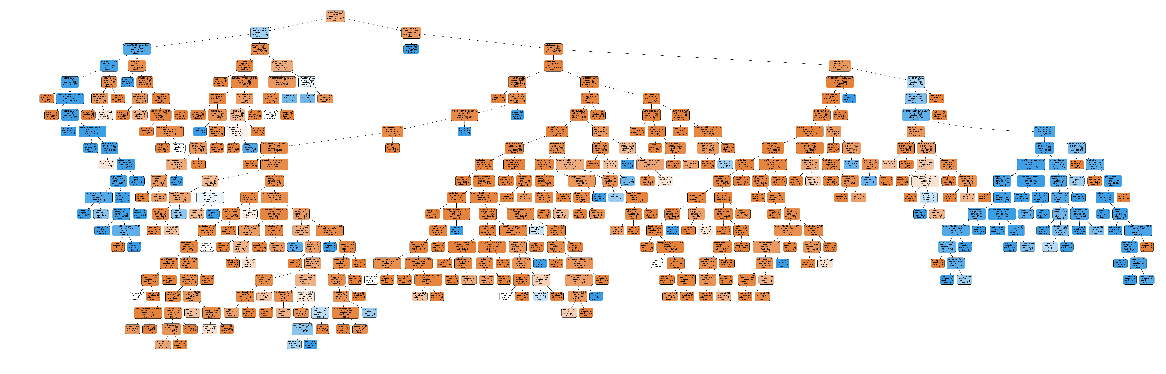

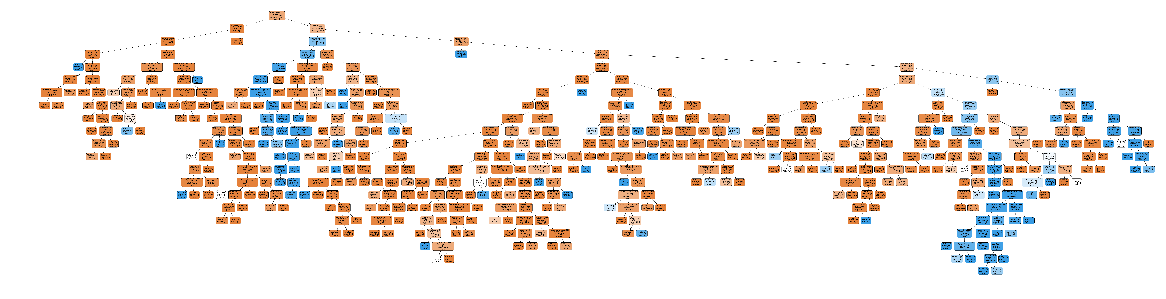

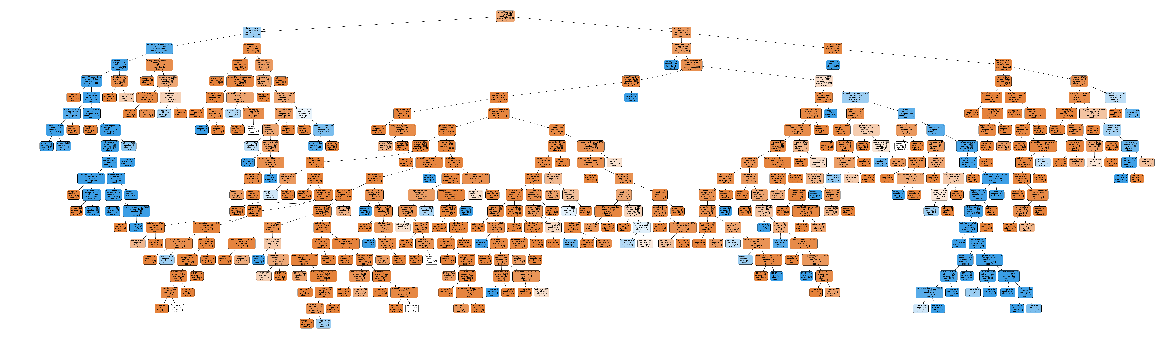

In [28]:
# Graphviz中未提供多棵树的绘制方法，所以我们遍历森林中的树，分别进行绘制
Estimators = rf.estimators_
# 遍历
for index, model in enumerate(Estimators):
    # 文件缓存
    dot_data = StringIO()
    # 将决策树导入到dot_data中
    export_graphviz(model , out_file=dot_data,
                         feature_names=df.columns[1:],
                         class_names=['0','1'],
                         filled=True, rounded=True,
                         special_characters=True)
    # 从数据中生成graph
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    # 将结果写入到png文件中
    graph.write_png('Rf{}.png'.format(index))
    # 绘制图像
    plt.figure(figsize = (20,20))
    plt.imshow(plt.imread('Rf{}.png'.format(index)))
    plt.axis('off')

## 随机森林特征分析

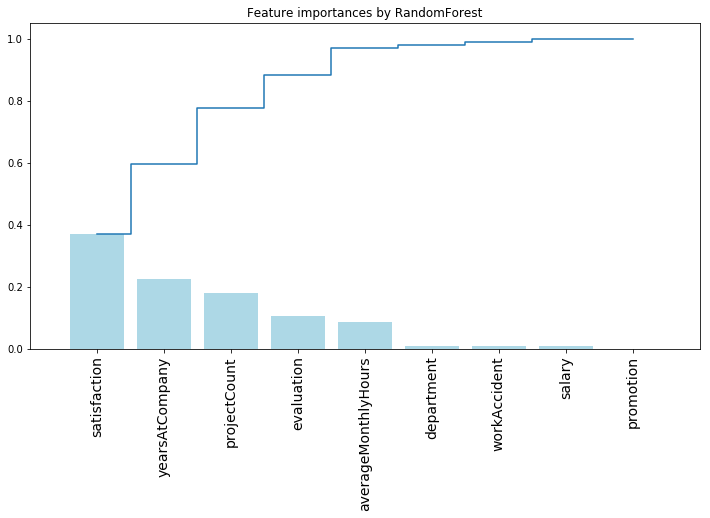

In [29]:
# 特征的重要程度
importances = rf.feature_importances_
# 特征名称
feat_names = df.drop(['turnover'],axis=1).columns
# 排序
indices = np.argsort(importances)[::-1]
# 绘图
plt.figure(figsize=(12,6))
plt.title("Feature importances by RandomForest")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

## ROC曲线

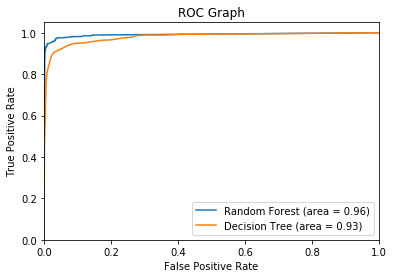

In [30]:
# ROC 图
from sklearn.metrics import roc_curve
# 计算ROC曲线
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])

plt.figure()

# 随机森林 ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)

# 决策树 ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
# 绘图
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()